# Měření BMI pomocí hloubkového senzoru
Tento úkol je zaměřen na využití dat z hloubkového senzoru - konkrétně ze senzoru **Microsoft Kinect**. Kinect je starší druh hloubkového senzoru, který umožňuje získávat hloubkové mapy v rozlišení až 640 × 480 pixelů. V každém pixelu je uložena hodnota vzdálenosti od senzoru v jednotkách mm. 

<img src="images/kinect_view.png" width="50%"/>

Firmware uvnitř senzoru dále umožňuje automaticky detekovat osoby a aproximovat je tzv. skeletonem. **Skeleton** je objekt, který je definován ve své jednodušší variantě 20 body těla. K automatické detekci osoby a vytvoření skeletonu je zapotřebí kalibraovat senzor pomocí utvoření tzv. "[**psi pózy**](https://www.google.cz/search?biw=1848&bih=978&tbm=isch&sa=1&ei=WO8DXIedG6iMrwT7qry4AQ&q=psi+pose&oq=psi+pose&gs_l=img.3...0.0..8771...0.0..0.0.0.......1......gws-wiz-img.Ak1KqQmBEao)" (podle řečkého písmene &Psi;). Body jsou vidět na následujícím obrázku.

<img src="images/kinect_joint_points.png" width="40%"/>

## Citace
[1] VELARDO, Carmelo a Jean-Luc DUGELAY. Weight estimation from visual body appearance. In: *2010 Fourth IEEE International Conference on Biometrics: Theory, Applications and Systems (BTAS)* [online]. IEEE, 2010, 2010, s. 1-6 [cit. 2018-12-02]. DOI: 10.1109/BTAS.2010.5634540. ISBN 978-1-4244-7581-0. Dostupné z: http://ieeexplore.ieee.org/document/5634540/ 

[2] PROKOPENKO, Stan. Human Figure Proportions - Average Figures - Dr. Paul Richer. *Proko - How to Draw*. [online]. 18.11.2013 [cit. 2015-05-10]. Dostupné z: http://www.proko.com/human-figure-proportions-average-richer/

### Import knihoven a konfigurace

In [1]:
%run ../svz.ipynb
import json
from pprint import pprint
import skimage.io

In [2]:
def tuple_elems_to_int(t):
    assert len(t) == 2, 'Only tuple with two elements is supported!'
    return (int(t[0]), int(t[1]))

def kq_of_line_segment(l_p1, l_p2):
    a = np.array([[l_p1[0], 1], [l_p2[0], 1]])
    b = np.array([l_p1[1], l_p2[1]])
    
    k, q = np.linalg.solve(a, b)
    
    return k, q

def normal_kq_in_point(p1, k, q):
    kn = -1/k
    qn = p1[1] - kn * p1[0]
    return kn, qn

def normal_line_start_end_points(point, k, q, dx):
    kn, qn = normal_kq_in_point(point, k, q)
    
    x = [point[0]-dx, point[0]+dx]
    y = [kn * x[0] + qn, kn * x[1] + qn]
    
    return (x[0], y[0]), (x[1], y[1])

def draw_norm_line_segment_in_point(l_p1, l_p2, point, dx, image):
    k,q = kq_of_line_segment(l_p1, l_p2)
    start, end = normal_line_start_end_points(point, k, q, dx)
    cv2.line(image, tuple_elems_to_int(start), tuple_elems_to_int(end), (255,255,255), 1, cv2.LINE_4)
    return image

def draw_contour(image, contour):
    cv2.drawContours(image, contour, -1, (255,255,255), 1, cv2.LINE_4)
    return image

In [3]:
def measure_distances_using_impro(contour, specified_points, measured_joints_pairs):
    '''???'''
    dists = []
    
    # Lengts of line segments to draw
    # ... it's highly sensitive to the size of body part
    # the values were changed experimentaly
    dxs = [20, 12, 25, 50]
    
    # ???
    just_contour = np.zeros_like(image)
    just_contour = draw_contour(just_contour, conts)
    
    # ???
    dists = []
    for i, point in enumerate(specified_points):
        p1 = measured_joint_pairs[i][0]
        p2 = measured_joint_pairs[i][1]
        
        # ???
        norm_lines = np.zeros_like(just_contour)
        norm_lines = draw_norm_line_segment_in_point(p1, p2, point, dxs[i], norm_lines) ###

        # ???
        im = cv2.bitwise_and(just_contour, norm_lines)
        idx = np.transpose(np.nonzero(im))
        
        # this was used for testing the line lengths
        #plot_images(norm_lines)
        #plot_images(im)

        # ???
        for j in range(0, len(idx)-1):
            dist = distance_cm(idx[j], idx[j+1], k)

            # I had to change this to 2*k, because I was getting one extra distance of 0.7578 when measuring d7 
            if dist > 2*k:
                dists.append(dist)

    # I was getting assertion error despite having 4 measured distances that seem correct
    #print(len(dists))
    #assert len(dists) != 4, 'You don\'t have enough points for measure distances. You probably chose RIGHT arm, hand, etc. Try choosing lef ones.'

    # ???
    return dists[0], dists[1], dists[2], dists[3]

In [4]:
def distance_cm(p1, p2, k):
    '''Distance between two points multiplied by k'''
    return np.linalg.norm(np.array(p1) - np.array(p2)) * k

def point_in_distance(p1, p2, frac):
    '''Creates point in specific distance (fraction) between two points'''
    assert type(p1) is type(tuple()), 'Bod p1 není TUPLE!'
    assert type(p2) is type(tuple()), 'Bod p2 není TUPLE!'
    
    dx = abs(p1[0] - p2[0])
    dy = abs(p1[1] - p2[1])
    
    p_new_x = min(p1[0],p2[0]) + (dx * frac)
    p_new_y = min(p1[1],p2[1]) + (dy * frac)
    
    return (p_new_x, p_new_y)

def recount_joints(meta, crop_tl):
    '''Recounts joints coordinates if you crop the default image and returns new meta dict.'''
    meta_new = dict()
    for key in meta.keys():
        x = meta[key][0] - crop_tl[0]
        y = meta[key][1] - crop_tl[1]
        meta_new[key] = [x, y]
    
    return meta_new

---

## Úkol

K výpočtu [body mass indexu (BMI)](https://cs.wikipedia.org/wiki/Index_t%C4%9Blesn%C3%A9_hmotnosti) jsou k dispozici nasnímaná data hloubkové mapy a metadata. Výpočet pro odhad hmotnosti vychází z publikace [1]. 

Za úkol je možné získat až **7 bodů** a až **2 prémiové**.

---

K výpočtu BMI bude zapotřebí změřit celkem 7 údajů. Údaje jsou přehledně zobrazeny v <a id='tab'>tabulce</a> na následujícím obrázku [1]. 

<img src="images/body_measurements.png" width="50%"/>

#### 1) Načtěte data
Načtěte data hloubkové mapy ve formátu `unit16` a k tomu metadata ve formátu `json`. Metadata obsahují souřadnice bodů pro všech 20 bodů skeletonu z hloubkové mapy a převodní konstantu `k` pro přepočet vzdáleností z pixelů na cm. Uložte si konstantu zvlášť a souřadnice bodů také.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

0.53588
{'ankle_left': [414, 349],
 'ankle_right': [352, 349],
 'elbow_left': [431, 173],
 'elbow_right': [325, 170],
 'foot_left': [414, 360],
 'foot_right': [351, 359],
 'hand_left': [467, 218],
 'hand_right': [286, 213],
 'head': [379, 77],
 'hip_center': [377, 188],
 'hip_left': [391, 201],
 'hip_right': [364, 201],
 'knee_left': [404, 285],
 'knee_right': [358, 285],
 'shoulder_center': [376, 109],
 'shoulder_left': [407, 129],
 'shoulder_right': [350, 127],
 'spine': [378, 177],
 'wrist_left': [459, 207],
 'wrist_right': [294, 202]}


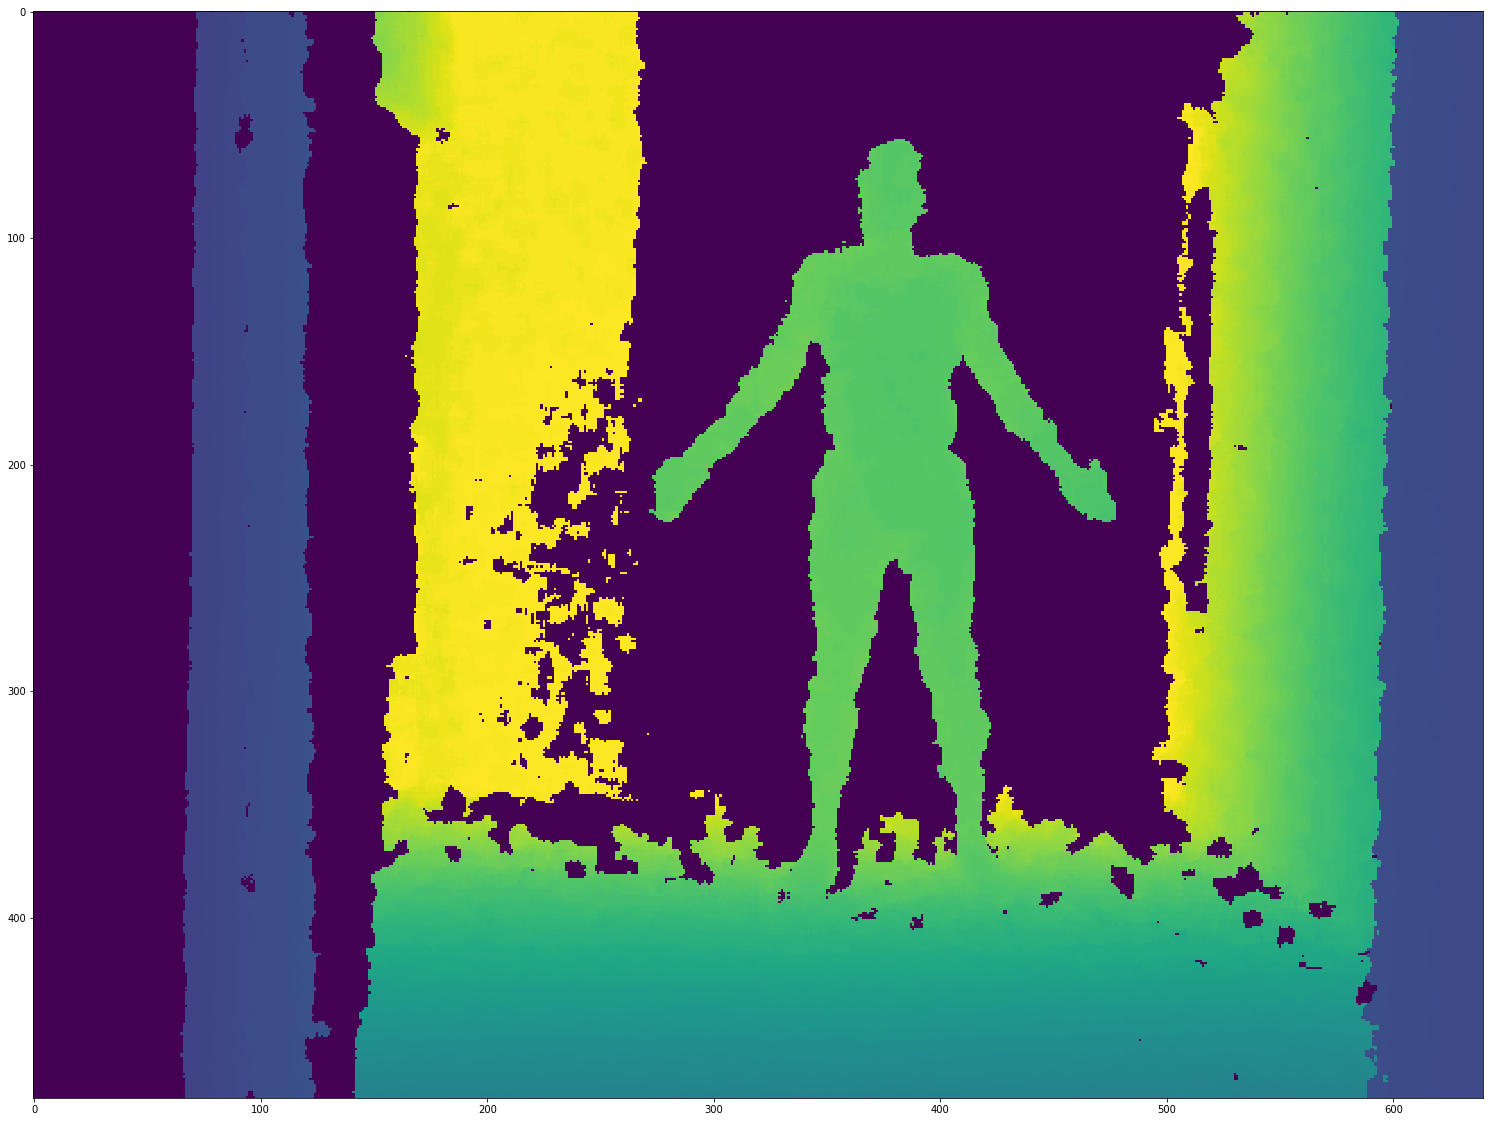

In [5]:
# Image open
depth = skimage.io.imread('./data/data.png') ###
plot_images(depth)

# Meta data load
with open('./data/data.json') as f: ###
    meta = json.load(f)

# Constant extraction
k = meta['k'] ###
del meta['k']

print(k)
pprint(meta)

#### 2) Zobrazte skeleton
Využijte metadata skeletonu a **zobrazte body skeletonu** na snímku hloubkové mapy. Zobrazte také **spoje bodů skeletonu** podle obrázku výše. Bude se hodit funkce, která je schopna vrátit **dvojice klíčů** ze slovníku `meta` pro body skeletonu, které jsou vedle sebe.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [6]:
def skeleton_tuples(num=19):
    joints = list()
    joints.append(['head', 'shoulder_center'])
    joints.append(['shoulder_center', 'shoulder_right'])
    joints.append(['shoulder_center', 'shoulder_left'])
    joints.append(['shoulder_center', 'spine'])
    
    joints.append(['shoulder_left', 'elbow_left'])
    joints.append(['elbow_left', 'wrist_left'])
    joints.append(['wrist_left', 'hand_left'])
    
    joints.append(['shoulder_right', 'elbow_right'])
    joints.append(['elbow_right', 'wrist_right'])
    joints.append(['wrist_right', 'hand_right'])
    
    joints.append(['spine', 'hip_center'])
    joints.append(['hip_center', 'hip_right'])
    joints.append(['hip_center', 'hip_left'])
    
    joints.append(['hip_left', 'knee_left'])
    joints.append(['knee_left', 'ankle_left'])
    joints.append(['ankle_left', 'foot_left'])
    
    joints.append(['hip_right', 'knee_right'])
    joints.append(['knee_right', 'ankle_right'])
    joints.append(['ankle_right', 'foot_right'])
    
    return joints[0:num]

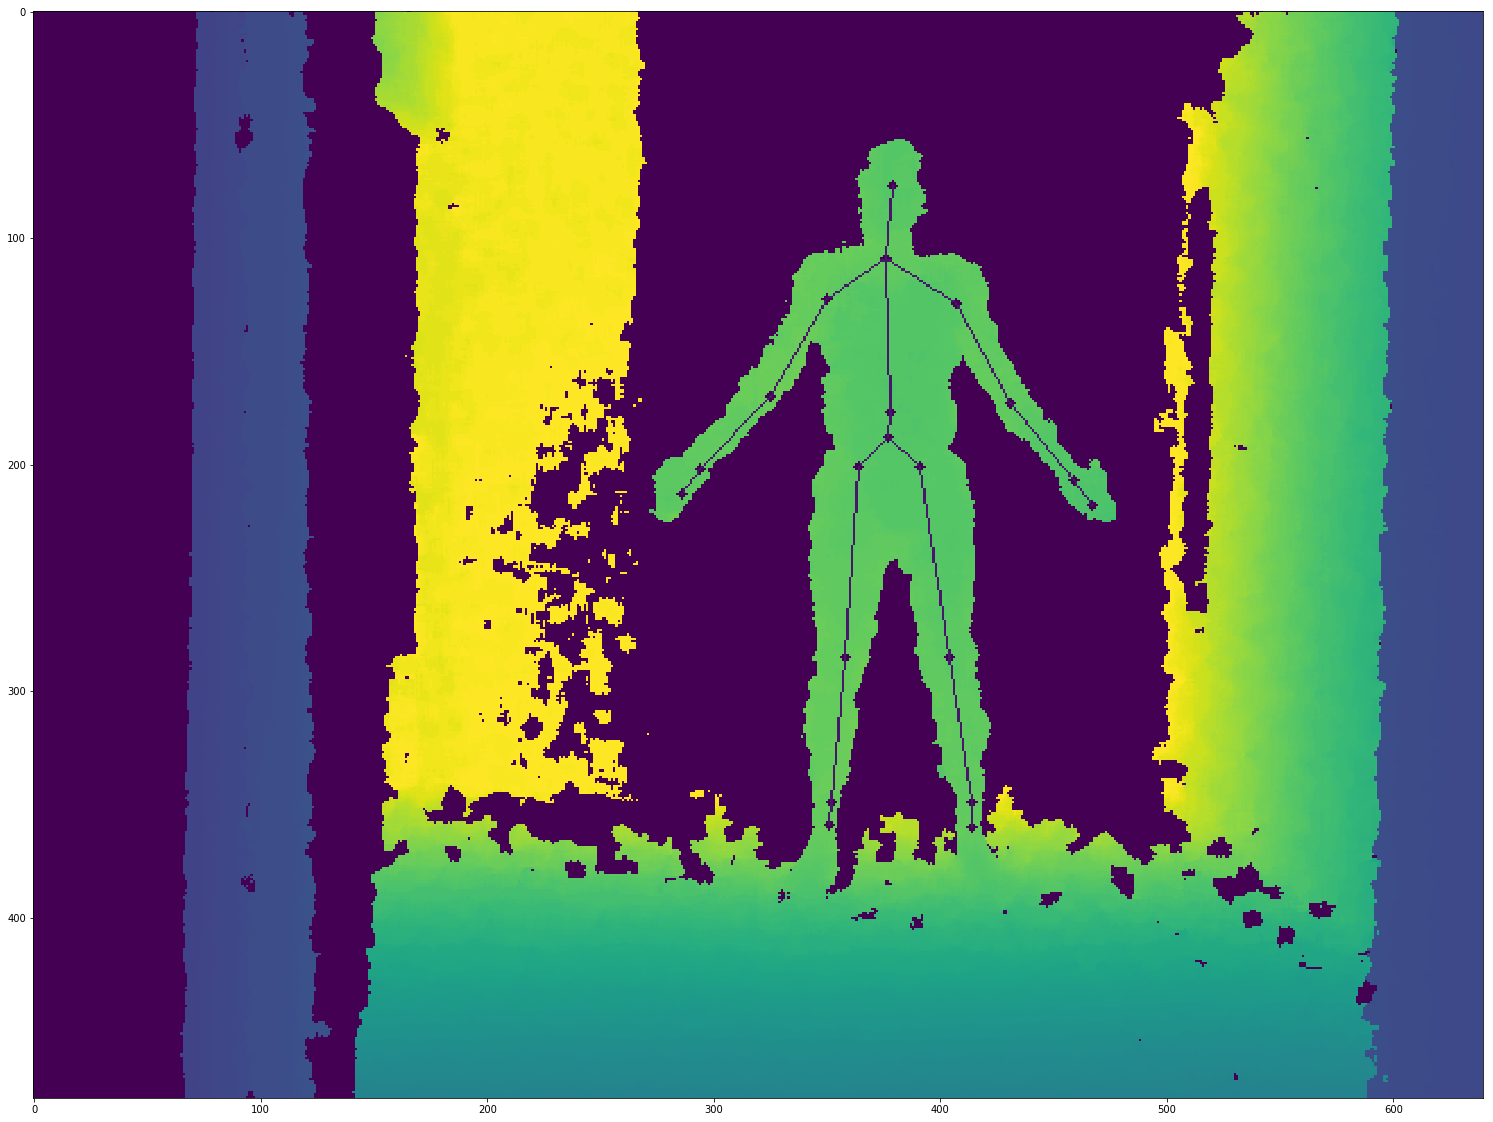

In [7]:
depth_draw = depth.copy()
skeleton_tuples()

# Draw all joints as circles
for point in meta.values():
    cv2.circle(depth_draw, tuple(point), 2, color=(0, 0, 255), thickness=-1)

# Draw all lines
joints = skeleton_tuples()
for joint in joints:
    cv2.line(depth_draw, tuple(meta[joint[0]]), tuple(meta[joint[1]]), color=(255, 0, 255))
    
plot_images(depth_draw)

#### 3) Změřte výšku osoby `f1`
S pomocí bodů skeletonu změřte výšku osoby. Vzdálenost mezi bodem `head` a vrškem hlavy aproximujte jako 1/14 změřené výšky [2]. Měřte výšku osoby v cm! Hodnotu výšky uložte do proměnné `f1`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

Výška osoby je 162.35 cm.


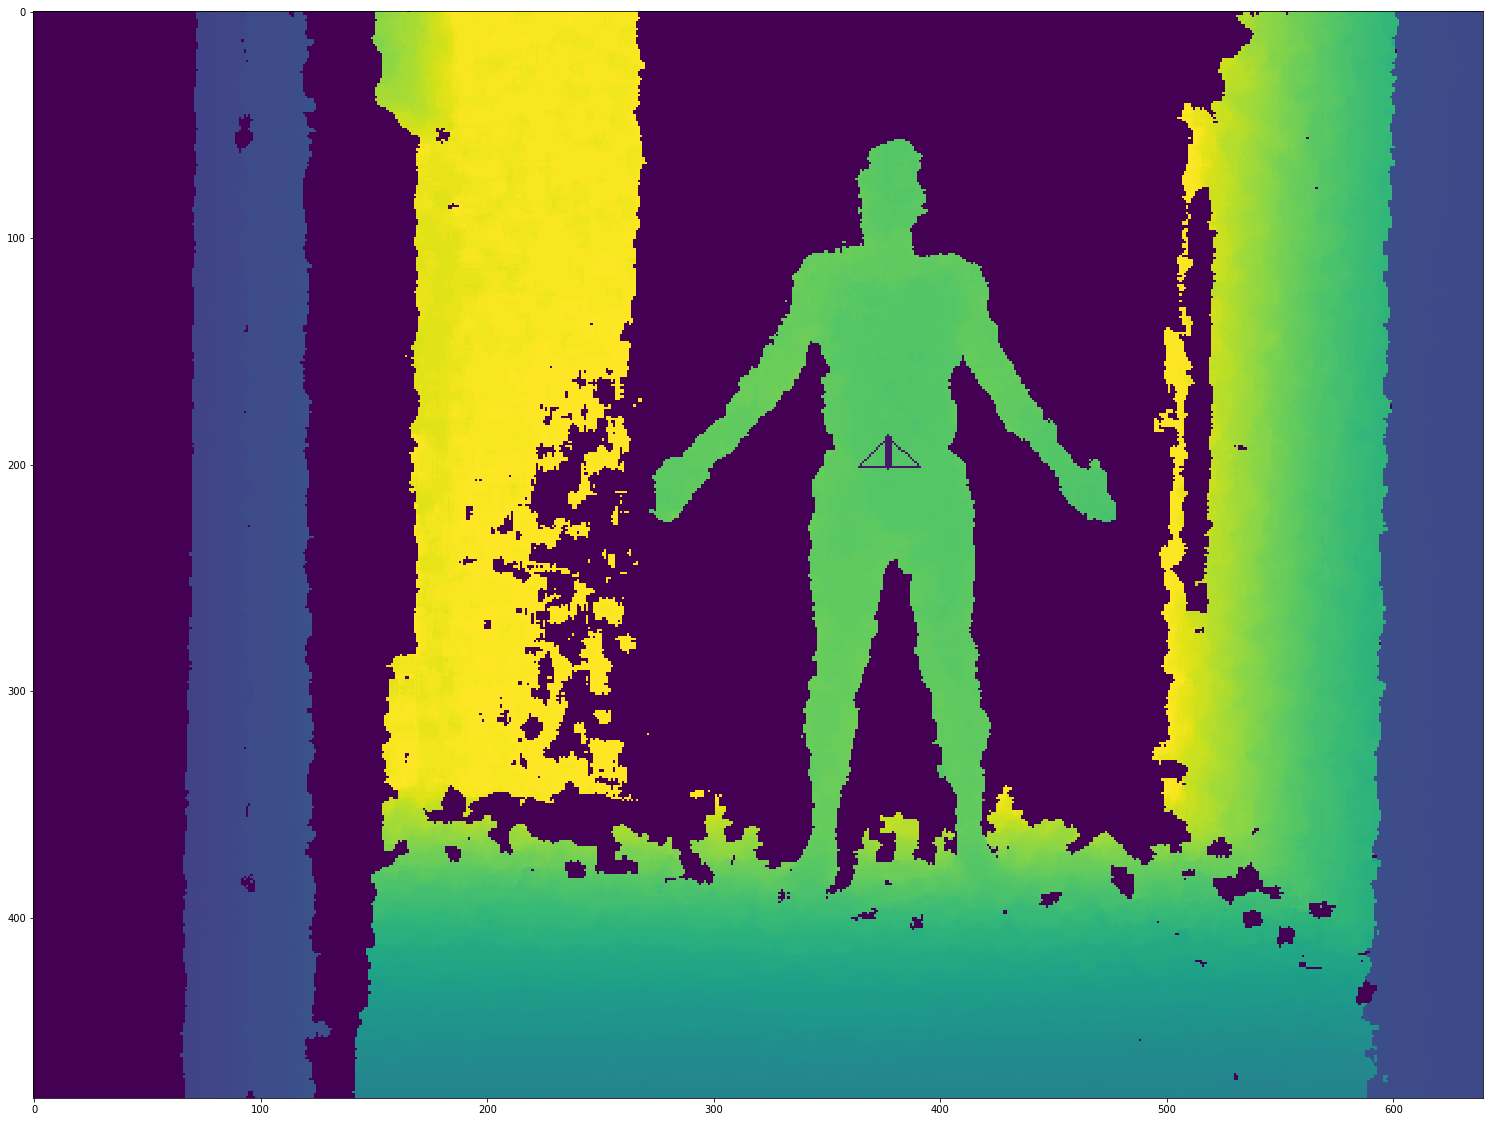

In [8]:
f1 = 0

'''
The body is not completely straight so I've decided, that meassuring height point by point 
is going to be more accurate
'''
f1 += distance_cm(meta['head'], meta['shoulder_center'], k)
f1 += distance_cm(meta['shoulder_center'], meta['spine'], k)
f1 += distance_cm(meta['spine'], meta['hip_center'], k)

'''
We need to add the height from hip_center to hip_right, the image should explain how I've done it
'''
depth_draw = depth.copy()
cv2.line(depth_draw, tuple(meta['hip_right']), tuple(meta['hip_center']), color=(255, 0, 255))
cv2.line(depth_draw, tuple(meta['hip_center']), tuple(meta['hip_left']), color=(255, 0, 255))
cv2.line(depth_draw, tuple(meta['hip_right']), tuple(meta['hip_left']), color=(255, 0, 255))
cv2.line(depth_draw, tuple(meta['hip_center']), (meta['hip_center'][0], meta['hip_right'][1]) \
         , color=(255, 0, 255), thickness=2)
plot_images(depth_draw)

f1 += distance_cm(meta['hip_center'], (meta['hip_center'][0], meta['hip_right'][1]), k)

f1 += distance_cm(meta['hip_right'], meta['knee_right'], k)
f1 += distance_cm(meta['knee_right'], meta['ankle_right'], k)
f1 += distance_cm(meta['ankle_right'], meta['foot_right'], k)

f1 += f1/14

print(f'Výška osoby je {f1:.2f} cm.')

#### 4) Segmentujte osobu z obrazu
Z hloubkové mapy segmentujte osobu. Můžete využít znalosti, že měřený subjekt dle metodiky měření stál **296 cm** od senzoru. Tloušťku osoby zvolte maximálně **50 cm**. Jako výsledek si uložte **konturu osoby**, protože se pak bude hodit dále.

Můžete si pomoci **ručním oříznutím** obrázku, avšak nezapomeňte pak **přepočítat souřadnice** bodů skeletonu! 

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

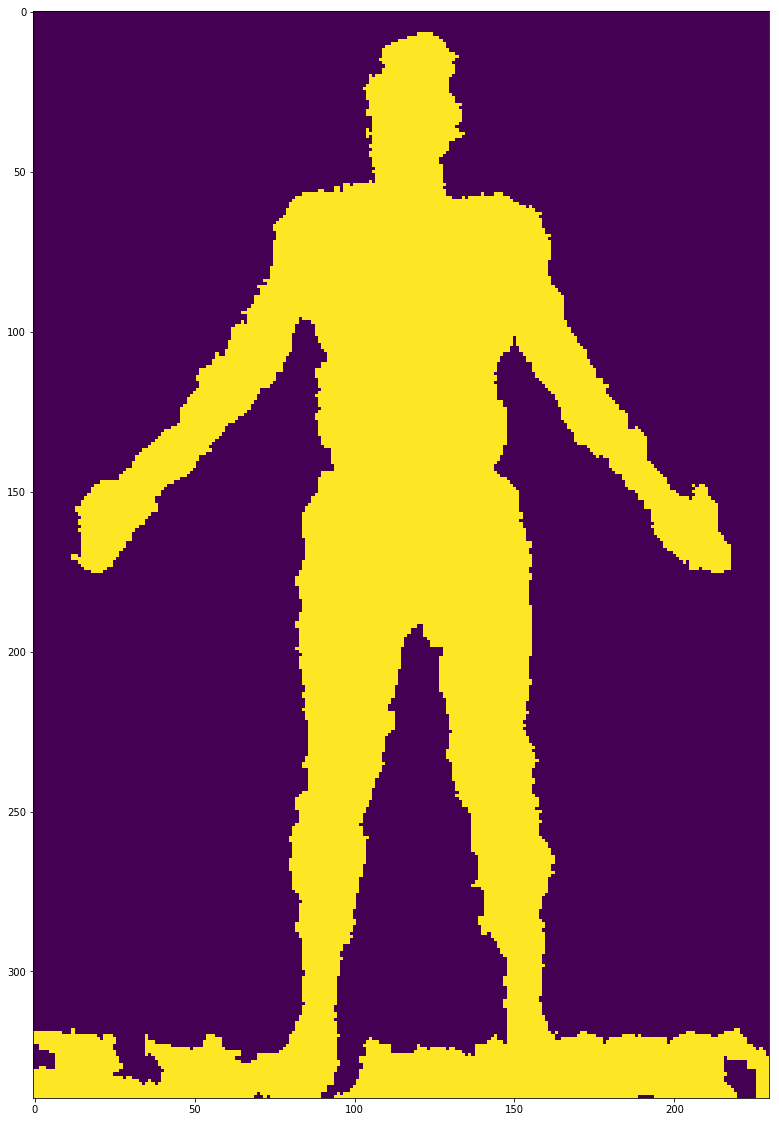

In [9]:
image = depth.copy()
image = to_gray(image)

# Don't forget to recount joints while cropping!
image = crop(image, 260, 50, 490, 390)
meta_new = recount_joints(meta, (270, 50))   

# Segmentation
dist = 2960
tol = 300
image_bin = segmentation_two_thresholds(image, dist-tol, dist+tol)

# Gets one final contour in form of np.ndarray
conts_drawn, _, conts = contours(image_bin, min_area=100)
plot_images(conts_drawn)

#### 5) Změřte další potřebné rozměry délku stehna `f2` a délku nadloktí `f4`
Změřte další rozměry potřebné k zisku odhadu hmotnosti člověka. Potřebné rozměry jsou zobrazené v [tabulce](#tab) na následujícícm obrázku. Rozměry uložte do proměnných `f2` a `f4`.

<div style="color: blue; text-align: right">[ 0.75 bodu ]</div>

In [10]:
f2 = distance_cm(meta['hip_right'], meta['knee_right'], k)
f4 = distance_cm(meta['shoulder_right'], meta['elbow_right'], k)

print(f2)
print(f4)

45.128605332369844
26.65430704906057


#### 6) Nalezněte body kontury pro další měření
Najděte polohy bodů pro měření šířky kontury osoby p_3, p_5, p_7 a p_6. 
- Bod pro měření **lýtka** leží ve 2/3 délky mezi body skeletonu `knee` a `ankle`.
- Bod pro měření **paže** leží ve 2/3 délky mezi body skeletonu `shoulder` a `elbow`.
- Bod pro měření **stehna** leží ve 4/5 délky mezi body skeletonu `hip`a `knee`.
- Bod pro měření **pasu** leží v bodě skeletonu `hip_center`.

Dále nalezněte vždy 2 body kontury, které leží na normále (= přímce kolmé) k přímce spojující výše zmíněné body skeletonu a změřte vzdálenosti mezi nimi `d3`, `d5` a `d7`.

Pro vzdálenost `d6` se využije přímky spojující bod skeletonu `shoulder_center` s bodem `hip_center`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [11]:
p_3 = point_in_distance(tuple(meta_new['knee_right']), tuple(meta_new['ankle_right']), 2/3)
p_5 = point_in_distance(tuple(meta_new['shoulder_left']), tuple(meta_new['elbow_left']), 2/3)
p_7 = point_in_distance(tuple(meta_new['hip_right']), tuple(meta_new['knee_right']), 4/5)
p_6 = tuple(meta_new['hip_center'])

points = [p_3, p_5, p_7, p_6]

In [12]:
measured_joint_pairs = [
    [ tuple(meta_new['knee_right']), tuple(meta_new['ankle_right']) ],
    [ tuple(meta_new['shoulder_left']), tuple(meta_new['elbow_left']) ],
    [ tuple(meta_new['hip_right']), tuple(meta_new['knee_right']) ],
    [ tuple(meta_new['hip_center']), tuple(meta_new['shoulder_center']) ]
]

d3, d5, d7, d6 = measure_distances_using_impro(conts, points, measured_joint_pairs)
print(d3, d5, d7, d6)

8.640805364316453 5.991320538912937 13.94318157626874 28.40164


#### 7) Spočítejte další potřebné rozměry obvod lýtka `f3`, obvod paže `f5` a obvod stehna `f7`
Předpokládejme, že lýtko, paže i stehno lze aproximovat geometrickým útvarem válce. Z obrazu jsme získali vzdálenosti kontury osoby v potřebných bodech. Potom výpočet obvodů `f3`, `f5` a `f7` lze získat dle následujícího vzorce.

<center>$f_i = \pi \cdot d_i$, pro $i \in \{3, 5, 7\}$</center>

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [13]:
f3 = math.pi * d3
f5 = math.pi * d5
f7 = math.pi * d7

print(f3)
print(f5)
print(f7)

27.145890653635846
18.822288590350524
43.80379680767442


#### 8) Spočítejte další potřebný rozměr obvod pasu `f6`
Předpokládejte, že pas nelze úplně aproximovat válcem. Tento rozměr vezmeme jako jeden hraniční. Jako druhý hraniční rozměr vezmeme dvojnásobek rozměru `d6`. Jejich průmerem pak vypočteme obvod pasu podle vzorce:

$$
f_6 = \frac{\pi \cdot d_6 + 2 \cdot d_6}{2}
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [14]:
f6 = (math.pi * d6 + 2 * d6)/2

print(f6)

73.014831786951


#### 9) Spočítejte odhad hmotnosti
Dle [1] lze spočítat odhad hmotnosti člověka v kg podle následujícího vzorce.

$$
m = -122,27 + 0,48 \cdot f_1 - 0,17 \cdot f_2 + 0,52 \cdot f_3 + 0,16 \cdot f_4 + 0,77 \cdot f_5 + 0,49 \cdot f6 + 0,58 \cdot f_7
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [15]:
m = -122.27 + 0.48*f1 - 0.17*f2 + 0.52*f3 + 0.16*f4 + 0.77*f5 + 0.49*f6 + 0.58*f7

print(f'Hmotnost osoby je {m:.2f} kg.')

Hmotnost osoby je 42.04 kg.


#### 10) Spočtěte BMI
Ze standardního vztahu vypočtěte BMI jako poměr hmotnosti $m$ v kg a výšky $h$ v m člověka.

$$
BMI = \frac{m}{h^2}
$$

<div style="color: blue; text-align: right">[ 0.5 bodu ]</div>

In [16]:
BMI = m / (f1/100)**2

print(f'Výsledné BMI je {BMI:.2f} kg/m2.')

Výsledné BMI je 15.95 kg/m2.
